# Boilerplate functions

In [15]:
import json
from nltk.tree import Tree
import seaborn as sns
import matplotlib.pyplot as plt


def fromlist(l):
    """
    :type l: list
    :param l: a tree represented as nested lists

    :return: A tree corresponding to the list representation ``l``.
    :rtype: Tree

    Convert nested lists to a NLTK Tree
    """
    if type(l) is not list:
        return l
    if type(l) == list and len(l) > 0:
        label = repr(l[0])
        if len(l) > 1:
            return Tree(label, [fromlist(child) for child in l[1:]])
        else:
            return label


def chomsky_normal_form(
    tree, factor="right", horzMarkov=None, vertMarkov=0, childChar="|", parentChar="^"
):
    # assume all subtrees have homogeneous children
    # assume all terminals have no siblings

    # A semi-hack to have elegant looking code below.  As a result,
    # any subtree with a branching factor greater than 999 will be incorrectly truncated.
    if horzMarkov is None:
        horzMarkov = 999

    # Traverse the tree depth-first keeping a list of ancestor nodes to the root.
    # I chose not to use the tree.treepositions() method since it requires
    # two traversals of the tree (one to get the positions, one to iterate
    # over them) and node access time is proportional to the height of the node.
    # This method is 7x faster which helps when parsing 40,000 sentences.

    nodeList = [(tree, [tree.label()])]
    while nodeList != []:
        node, parent = nodeList.pop()
        if isinstance(node, Tree):

            # parent annotation
            parentString = ""
            originalNode = node.label()
            if vertMarkov != 0 and node != tree and isinstance(node[0], Tree):
                parentString = "{}<{}>".format(parentChar, "-".join(parent))
                node.set_label(node.label() + parentString)
                parent = [originalNode] + parent[: vertMarkov - 1]

            # add children to the agenda before we mess with them
            for child in node:
                nodeList.append((child, parent))

            # chomsky normal form factorization
            if len(node) > 2:
                childNodes = []
                for child in node:
                    if isinstance(child, str) or isinstance(child, int):
                        childNodes.append(child)
                    else:
                        childNodes.append(child.label())
                #childNodes = [child.label() for child in node]
                nodeCopy = node.copy()
                node[0:] = []  # delete the children

                curNode = node
                numChildren = len(nodeCopy)
                for i in range(1, numChildren - 1):
                    if factor == "right":
                        newHead = "{}{}<{}>{}".format(
                            originalNode,
                            childChar,
                            "-".join(
                                childNodes[i : min([i + horzMarkov, numChildren])]
                            ),
                            parentString,
                        )  # create new head
                        newNode = Tree(newHead, [])
                        curNode[0:] = [nodeCopy.pop(0), newNode]
                    else:
                        newHead = "{}{}<{}>{}".format(
                            originalNode,
                            childChar,
                            "-".join(
                                childNodes[max([numChildren - i - horzMarkov, 0]) : -i]
                            ),
                            parentString,
                        )
                        newNode = Tree(newHead, [])
                        curNode[0:] = [newNode, nodeCopy.pop()]

                    curNode = newNode

                curNode[0:] = [child for child in nodeCopy]


Data dir: small
File: valid
Number of samples 10000


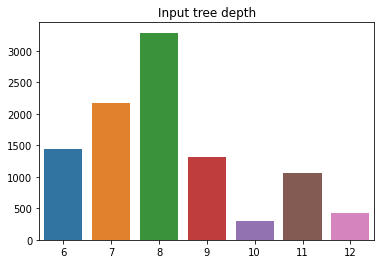

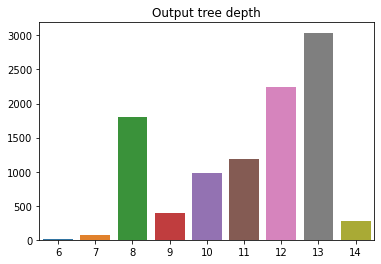

File: test
Number of samples 10000


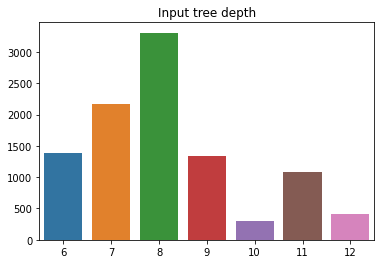

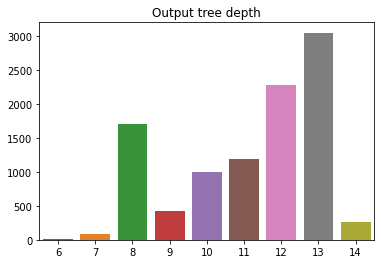

File: train
Number of samples 100000


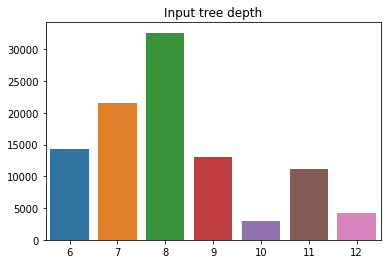

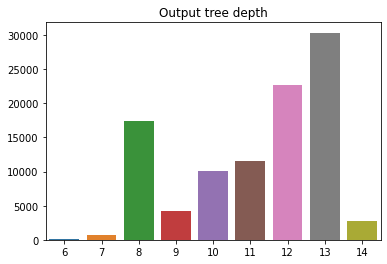

Data dir: large
File: valid
Number of samples 10000


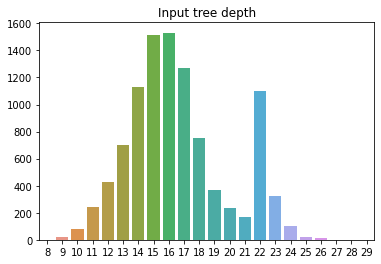

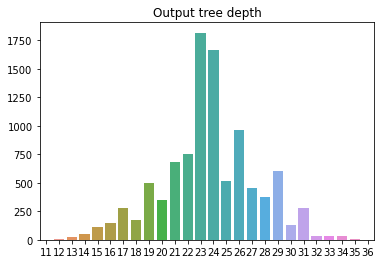

File: test
Number of samples 10000


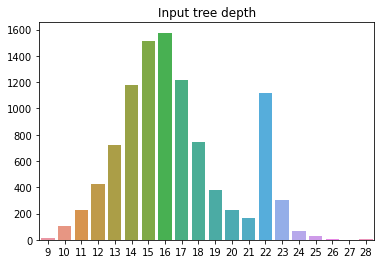

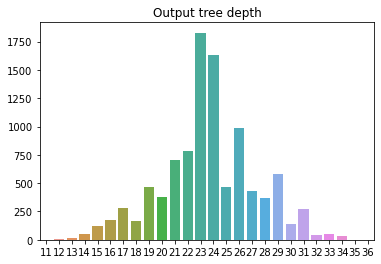

File: train
Number of samples 100000


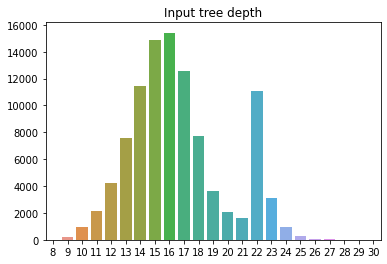

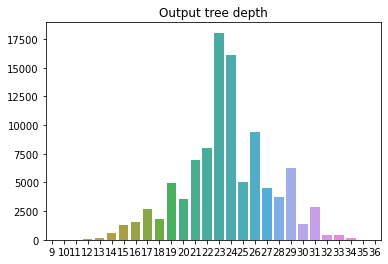

In [16]:
for data_dir in ['small']:#, 'large']:
    print(f'Data dir: {data_dir}')
    for data_filename in ['valid', 'test', 'train']:
        input_tree_depth_count = {}
        output_tree_depth_count = {}

        print(f'File: {data_filename}')
        with open(f'../data_files/For2Lam/{data_dir}/progs_{data_filename}.json', 'r') as f:
            data = json.load(f)
        print(f'Number of samples {len(data)}')
        for d in data:
            x = d['for_tree']
            y = d['lam_tree']
            x_tree = fromlist(x)
            y_tree = fromlist(y)

            chomsky_normal_form(x_tree)
            chomsky_normal_form(y_tree)

            input_height = x_tree.height()
            output_height = y_tree.height()
            
            if input_height not in input_tree_depth_count:
                input_tree_depth_count[input_height] = 0
            if output_height not in output_tree_depth_count:
                output_tree_depth_count[output_height] = 0
            
            input_tree_depth_count[input_height] += 1
            output_tree_depth_count[output_height] += 1
        keys = list(input_tree_depth_count.keys())
        # get values in the same order as keys, and parse percentage values
        vals = list(input_tree_depth_count.values())
        plt.title('Input tree depth')
        sns.barplot(x=keys, y=vals)
        plt.show()

        keys = list(output_tree_depth_count.keys())
        # get values in the same order as keys, and parse percentage values
        vals = list(output_tree_depth_count.values())
        plt.title('Output tree depth')
        sns.barplot(x=keys, y=vals)
        plt.show()

            